<a href="https://colab.research.google.com/github/benedettoscala/ifttt-code-generator/blob/main/fine_tuning_mistral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Environment Setup and Authentication
This section sets up the necessary environment by installing dependencies, importing required libraries, and authenticating with Hugging Face.

#### **Dependency Installation**
- Several essential libraries are installed:
  - `transformers`: Provides pre-trained models and tokenizers.
  - `peft`: Enables parameter-efficient fine-tuning techniques.
  - `accelerate`: Optimizes training performance on different hardware configurations.
  - `trl`: Supports reinforcement learning for transformers.
  - `datasets`: Provides easy access to various datasets.
  - `sentencepiece`: Required for tokenization of certain models.
  - `bitsandbytes`: Enables efficient quantization techniques for large models.
  - `rouge_score`: Used for text evaluation.

#### **Library Imports**
- The script imports key libraries such as:
  - `transformers` for model handling.
  - `peft` for efficient fine-tuning.
  - `torch` for deep learning operations.
  - `pandas` for dataset manipulation.
  - `datasets` for handling data structures compatible with Hugging Face.

#### **Authentication with Hugging Face**
- The script retrieves the `HUGGINGFACE_TOKEN` stored in Google Colab’s `userdata`.
- It logs into Hugging Face using `huggingface-cli login` to enable access to pre-trained models, datasets, and private repositories.

#### **Repository Cloning**
- The script clones the GitHub repository `ifttt-code-generator`, which contains the necessary code for the project.
- After cloning, it navigates to the repository directory and pulls the latest updates.

This setup ensures that all required dependencies are installed, authentication is handled securely, and the latest project files are available for further development.


In [ ]:
%%capture

!pip install transformers==4.36.2
!pip install -U peft
!pip install -U accelerate
!pip install -U trl
!pip install datasets==2.16.0
!pip install sentencepiece
!pip install -U bitsandbytes
!pip install rouge_score

In [ ]:
!pip install matplotlib
!pip install numpy

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
import torch
import pandas as pd
from datasets import Dataset


In [ ]:
!pip install ipywidgets

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
#from google.colab import userdata
#secret_hf = userdata.get('HUGGINGFACE_TOKEN')
#!huggingface-cli login --token $secret_hf

In [ ]:
!git clone https://github.com/benedettoscala/ifttt-code-generator
%cd ifttt-code-generator/
!git pull

### Dataset Processing and Tokenization
This section loads, cleans, and tokenizes the dataset using the `Mistral-7B-Instruct-v0.2` tokenizer.

#### **Tokenizer Setup**
- The tokenizer is loaded from Hugging Face using `AutoTokenizer.from_pretrained()`.
- If the tokenizer does not have a defined padding token, it is set to the EOS token to ensure proper tokenization.

#### **Dataset Loading and Cleaning**
- The dataset is loaded from a CSV file (`cleaned_and_combined.csv`).
- Missing values and duplicate entries are removed from the `permission_df`filter_code` columns.

#### **Tokenization and Length Calculation**
- Each text sample is tokenized separately:
  - **Description tokens**: Tokenized without truncation to capture full input lengths.
  - **Code tokens**: Tokenized separately for length analysis.
  - **Combined tokens**: The description and code are concatenated using a separator (`\n###\n`), then tokenized.
- The tokenized lengths for descriptions, code snippets, and combined text are stored for statistical analysis.

#### **Statistical Analysis**
- Minimum, maximum, mean, and median token lengths are computed and printed for each category.

#### **Visualization**
- A histogram is generated to visualize the distribution of token lengths for the combined text.
- A reference line is drawn at **512 tokens** to indicate a common model limit.

This analysis helps assess whether input sequences fit within model constraints and guide preprocessing decisions.


In [ ]:
%cd ifttt-code-generator/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# Carica il tokenizer
model_name = "google/codegemma-7b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Imposta il pad token se necessario
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Carica il dataset
csv_path = "datasets/new_dataset.csv"
df = pd.read_csv(csv_path)

In [3]:
df.dropna()

#reset indexes
df.reset_index(drop=True, inplace=True)

In [4]:
df

,permission_df,filter_code
0,if New pink line alert (trigger_service: Chica...,var Hour = Meta.currentUserTime.hour() var Day...
1,if New bus advisory (trigger_service: NJ Trans...,var Hour = Meta.currentUserTime.hour() var Day...
2,if New DART rider alert (trigger_service: DART...,var Hour = Meta.currentUserTime.hour() var Day...
3,if New tweet by a specific user (trigger_servi...,"if (Twitter.newTweetByUser.Text.indexOf(""SNES""..."
4,if New feed item (trigger_service: RSS Feed) t...,"if(Feed.newFeedItem.EntryContent.indexOf(""@"") ..."
...,...,...
610,if Door opened (trigger_service: MyQ) then Act...,var timeOfDay = Meta.currentUserTime.hour() ...
611,if You enter an area (trigger_service: Locatio...,var timeOfDay = Meta.currentUserTime.hour() if...
612,if You enter an area (trigger_service: Locatio...,var timeOfDay = Meta.currentUserTime.hour(); ...
613,if You enter an area (trigger_service: Locatio...,var timeOfDay = Meta.currentUserTime.hour() if...


Statistiche per la descrizione:
  Min: 22
  Max: 38
  Media: 27.270049099836335
  Mediana: 27.0

Statistiche per il codice:
  Min: 10
  Max: 23290
  Media: 206.06219312602292
  Mediana: 60.0

Statistiche per il testo completo (descrizione + codice):
  Min: 39
  Max: 23321
  Media: 235.33224222585926
  Mediana: 92.0



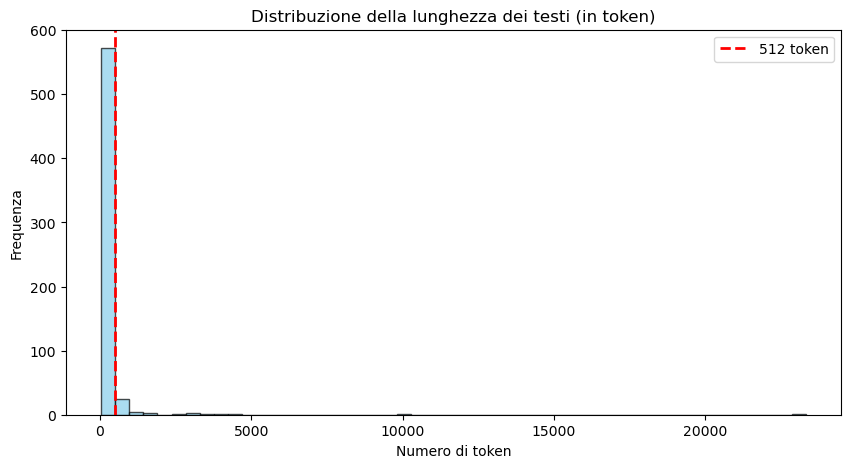

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# Carica il tokenizer
model_name = "google/codegemma-7b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Imposta il pad token se necessario
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Carica il dataset
csv_path = "datasets/new_dataset.csv"
df = pd.read_csv(csv_path)

# Pulizia: rimuovi eventuali righe con valori mancanti o duplicati
df.dropna(subset=["permission_df", "filter_code"], inplace=True)
#df.drop_duplicates(subset=["permission_df", "filter_code"], inplace=True)

# Imposta il separatore usato per combinare descrizione e codice
separator = "\n###\n"

# Liste per memorizzare le lunghezze (in token) per ciascun esempio
description_lengths = []
code_lengths = []
combined_lengths = []

# Itera sulle righe del dataset e tokenizza
for _, row in df.iterrows():
    description = row["permission_df"]
    code = row["filter_code"]

    # Tokenizza la descrizione (senza troncamento, per avere la lunghezza completa)
    desc_tokens = tokenizer.encode(description, truncation=False)
    # Tokenizza il codice
    code_tokens = tokenizer.encode(code, truncation=False)
    # Tokenizza il testo completo: descrizione + separatore + codice
    combined_text = description + separator + code
    combined_tokens = tokenizer.encode(combined_text, truncation=False)

    description_lengths.append(len(desc_tokens))
    code_lengths.append(len(code_tokens))
    combined_lengths.append(len(combined_tokens))

# Calcola statistiche per ciascuna serie di lunghezze
def print_stats(name, lengths):
    print(f"Statistiche per {name}:")
    print("  Min:", np.min(lengths))
    print("  Max:", np.max(lengths))
    print("  Media:", np.mean(lengths))
    print("  Mediana:", np.median(lengths))
    print()

print_stats("la descrizione", description_lengths)
print_stats("il codice", code_lengths)
print_stats("il testo completo (descrizione + codice)", combined_lengths)

# Visualizza la distribuzione della lunghezza del testo completo
plt.figure(figsize=(10, 5))
plt.hist(combined_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(512, color='red', linestyle='dashed', linewidth=2, label="512 token")
plt.title("Distribuzione della lunghezza dei testi (in token)")
plt.xlabel("Numero di token")
plt.ylabel("Frequenza")
plt.legend()
plt.show()


In [ ]:
!pip install -U scikit-learn

In [5]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq
)

In [7]:
#funzione per trovare i moduli lineare come detto da quel paper su QLoRA
def find_target_modules(model):
    # Initialize a Set to Store Unique Layers
    unique_layers = set()

    # Iterate Over All Named Modules in the Model
    for name, module in model.named_modules():
        # Check if the Module Type Contains 'Linear4bit'
        if "Linear4bit" in str(type(module)):
            # Extract the Type of the Layer
            layer_type = name.split('.')[-1]

            # Add the Layer Type to the Set of Unique Layers
            unique_layers.add(layer_type)

    # Return the Set of Unique Layers Converted to a List
    return list(unique_layers)

### Model Loading and LoRA Configuration
This section loads the base model, applies 4-bit quantization for memory efficiency, and configures LoRA (Low-Rank Adaptation) for fine-tuning.

#### **Model Quantization Setup**
- The base model `"mistralai/Mistral-7B-Instruct-v0.2"` is selected for fine-tuning.
- `BitsAndBytesConfig` is used to enable **4-bit quantization**, which reduces memory consumption while maintaining performance:
  - `nf4` (Normal Float 4) is chosen as the quantization type.
  - `bfloat16` is used for computations to balance precision and efficiency.
  - `bnb_4bit_use_double_quant=False` prevents additional quantization layers to keep training stable.

#### **Model and Tokenizer Initialization**
- The base model is loaded with the quantization settings and mapped automatically to available hardware (`device_map="auto"`).
- The tokenizer is loaded and configured:
  - The padding token is set to the EOS token to handle padding properly.
  - The padding side is set to `"left"` to align inputs correctly for causal language modeling.

#### **LoRA Configuration for Efficient Fine-Tuning**
- `prepare_model_for_kbit_training()` is applied to disable gradients on frozen quantized layers, optimizing the model for fine-tuning.
- **LoRA Parameters:**
  - `r=16`: The rank of the LoRA adaptation matrices (higher values increase capacity).
  - `lora_alpha=32`: Controls scaling of LoRA updates.
  - `lora_dropout=0.05`: Adds dropout regularization to prevent overfitting.
  - `bias="none"`: No bias parameters are added.
  - `task_type="CAUSAL_LM"`: Specifies the model is a causal language model.
  - `target_modules`: LoRA is applied to key transformer components (`q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`), which control attention mechanism computations.

#### **Printing Trainable Parameters**
- The script prints out the number of trainable parameters after applying LoRA, ensuring only the lightweight LoRA adapters are updated while keeping the main model frozen.

This setup enables efficient fine-tuning on large-scale language models with minimal computational overhead.


In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [7]:
import torch
if torch.cuda.is_available():
    print('it works')

it works


In [8]:
import torch
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig
)

# Sostituisci con il tuo modello
base_model = "google/codegemma-7b"

# Configurazione per la quantizzazione 4-bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True
)

# Impostiamo i limiti di memoria massima (indicativi!) per GPU e CPU.
# - "0": la tua prima GPU (se ne hai solo una).
# - "cpu": la CPU.
#
# Ad esempio, se hai una GPU da 12GB o 16GB, puoi regolare la voce "0" di conseguenza.
# "cpu" può essere anche maggiore (in GB) se hai abbastanza RAM di sistema.
max_memory = {
    0: "8GiB",  # Limite (fittizio) di 10 GiB sulla GPU
    "cpu": "16GiB"  # Limite di 48 GiB sulla CPU
}

print("Caricamento del modello base (con offload su CPU/GPU)...")
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16,
    device_map="auto",         # lascia decidere a HF come piazzare i layer
    #max_memory=max_memory      # impone i limiti di memoria
)

print("Caricamento del tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(base_model)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# Prepara il modello per k-bit training (disabilita i gradienti del modello base)
model = prepare_model_for_kbit_training(model)

# Configurazione LoRA (puoi ridurre r se serve ulteriore risparmio)
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=find_target_modules(model),
)

print("Applicazione di LoRA al modello...")
model = get_peft_model(model, lora_config)

print("Parametri allenabili:")
model.print_trainable_parameters()


Caricamento del modello base (con offload su CPU/GPU)...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Caricamento del tokenizer...
Applicazione di LoRA al modello...
Parametri allenabili:
trainable params: 50,003,968 || all params: 8,587,684,864 || trainable%: 0.5823


In [9]:
# Caricamento e pulizia del dataset
csv_path = "datasets/new_dataset.csv"
df = pd.read_csv(csv_path)

df.dropna(subset=["permission_df", "filter_code"], inplace=True)

#drop duplicates
#df.drop_duplicates(subset=["permission_df", "filter_code"], inplace=True)

#Suddivisione train   e val
train_df, eval_df = train_test_split(df, test_size=0.356, random_state=42)

train_dataset = Dataset.from_pandas(train_df)
eval_dataset  = Dataset.from_pandas(eval_df)

In [10]:
eval_dataset

Dataset({
    features: ['permission_df', 'filter_code', '__index_level_0__'],
    num_rows: 200
})

In [ ]:
!pip install bitsandbytes>=0.43.0

### Tokenization and Data Collation
This section preprocesses the dataset by tokenizing input sequences and preparing them for training.

#### **Tokenization Process**
- The function `tokenize_function` processes the dataset by:
  1. **Concatenating Descriptions and Code:**  
     - A separator (`\n###\n`) is used to distinguish between the description and the corresponding code.
  2. **Tokenizing the Full Input:**  
     - Texts are tokenized with a max length of `256` tokens and padded using `"max_length"` to ensure consistent input sizes.
  3. **Calculating Prompt Lengths:**  
     - The same tokenization settings are applied to the prompt alone (description + separator).
     - The number of tokens in the prompt (excluding padding) is recorded.
  4. **Creating Labels:**  
     - Tokens corresponding to the prompt are masked using `-100` (ignored during loss computation).
     - The remaining part (code) is left unchanged for the model to learn from.

#### **Dataset Tokenization**
- The `train_dataset` and `eval_dataset` are processed using `dataset.map()`, applying the tokenization function in batches.

This setup ensures efficient tokenization and dynamic padding, making training more stable and memory-efficient.


In [11]:
from transformers import DataCollatorWithPadding
# Funzione di tokenizzazione
def tokenize_function(examples):
    separator = "\n###\n"

    # Concateno desc + code
    full_text = [
        desc + separator + code
        for desc, code in zip(examples["permission_df"], examples["filter_code"])
    ]

    # Tokenizza con padding e truncation "coerenti"
    tokenized = tokenizer(
        full_text,
        truncation=True,
        max_length=256,
        padding="max_length"  # cosi ottengo shape costanti
    )

    # Calcolo la lunghezza del prompt con gli stessi identici parametri
    prompt_text = [
        desc + separator
        for desc in examples["permission_df"]
    ]
    tokenized_prompt = tokenizer(
        prompt_text,
        truncation=True,
        max_length=256,
        padding="max_length"  # stesse impostazioni
    )
    prompt_lengths = [
        sum(p_id != tokenizer.pad_token_id for p_id in p_ids)
        for p_ids in tokenized_prompt["input_ids"]
    ]

    # Costruisco le label: maschero la parte del prompt con -100
    labels = []
    for i, seq in enumerate(tokenized["input_ids"]):
        prompt_len = prompt_lengths[i]
        # Il prompt è su N token e la rimanente parte su (512 - N) token
        masked_labels = [-100]*prompt_len + seq[prompt_len:]
        labels.append(masked_labels)

    tokenized["labels"] = labels
    return tokenized




train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset  = eval_dataset.map(tokenize_function,  batched=True)

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [12]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DaisLabTBB\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### Seq2Seq Training Setup with Custom Metrics
This section configures and executes the training process using the `Trainer` API with custom evaluation metrics.

#### **Training Arguments Configuration**
- The `TrainingArguments` class is used to define key training parameters:
  - **Training epochs:** `5` full passes over the dataset.
  - **Batch size:** `2` per device with `gradient_accumulation_steps=4` to simulate a larger batch.
  - **Learning rate:** `1e-4` with a `cosine` scheduler for gradual decay.
  - **Weight decay:** `0.01` for regularization.
  - **Mixed precision:** `bf16=True` for optimized training on supported GPUs.
  - **Evaluation strategy:** `epoch`, meaning evaluation occurs at the end of each epoch.
  - **Checkpointing:** Saves model checkpoints every `100` steps, keeping the last `3` checkpoints.

#### **Custom Metric Computation**
- The `compute_metrics` function evaluates model performance using:
  - **BLEU Score:** Measures word overlap between predictions and references, using smoothing for short sentences.
  - **METEOR Score:** Accounts for synonyms, stemming, and word order to evaluate translations.
  - **ROUGE Score:** Compares n-gram matches between generated and reference texts.
- **Key Preprocessing Steps:**
  - Converts `-100` labels (ignored during training) into the tokenizer's padding token.
  - Decodes predictions and references into readable text before evaluation.
  - Computes and averages scores across all samples.

#### **Trainer Initialization**
- The `Trainer` API is used to manage training:
  - The model is fine-tuned on `train_dataset` and evaluated on `eval_dataset`.
  - The tokenizer is provided for text processing.
  - The `compute_metrics` function is integrated to track performance.

#### **Training Execution and Model Saving**
- The model training is initiated with `trainer.train()`.
- The final fine-tuned model, including **LoRA adapters and quantization settings**, is saved to `"./results/best_model"`.


In [13]:
from transformers import Seq2SeqTrainingArguments, Trainer
from datasets import load_metric
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

# Impostazioni di training specifiche per Seq2Seq
training_args = TrainingArguments(
    output_dir="../NLPMODELS/codegemma",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    warmup_ratio=0.03,
    lr_scheduler_type="cosine",
    learning_rate=1e-4,
    weight_decay=0.01,
    max_grad_norm=1.0,
    #save_steps=100,
    logging_steps=2,
    save_strategy="epoch",
    #eval_strategy="epoch",
    load_best_model_at_end=False,
    save_total_limit=3,
    fp16=False,
    bf16=True,
    #report_to="wandb",
    #predict_with_generate=True
)

# Funzione per il calcolo delle metriche
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Se predictions è un tuple, prendiamo la prima parte
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # Se predictions è un tensor, trasformiamolo in numpy
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()

    # Se i predictions contengono logits invece di id di token, facciamo argmax
    if predictions.dtype not in [int, 'int32', 'int64']:
        predictions = predictions.argmax(axis=-1)

    labels = np.where(labels == -100, tokenizer.pad_token_id, labels)

    # Decodifica
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Calcolo metriche BLEU, METEOR, ROUGE ecc.
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    from nltk.translate.meteor_score import meteor_score
    from rouge_score import rouge_scorer

    # BLEU
    bleu_scores = [
        sentence_bleu(
            [ref.split()], pred.split(),
            smoothing_function=SmoothingFunction().method1
        )
        for pred, ref in zip(decoded_preds, decoded_labels)
    ]
    avg_bleu = sum(bleu_scores) / len(bleu_scores)

    # METEOR
    meteor_scores = [
        meteor_score([ref.split()], pred.split())
        for pred, ref in zip(decoded_preds, decoded_labels)
    ]
    avg_meteor = sum(meteor_scores) / len(meteor_scores)

    # ROUGE
    rouge = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    rouge_scores = [
        rouge.score(ref, pred)
        for pred, ref in zip(decoded_preds, decoded_labels)
    ]
    avg_rouge1 = sum(score["rouge1"].fmeasure for score in rouge_scores) / len(rouge_scores)
    avg_rouge2 = sum(score["rouge2"].fmeasure for score in rouge_scores) / len(rouge_scores)
    avg_rougeL = sum(score["rougeL"].fmeasure for score in rouge_scores) / len(rouge_scores)

    return {
        "bleu": avg_bleu,
        "meteor": avg_meteor,
        "rouge1": avg_rouge1,
        "rouge2": avg_rouge2,
        "rougeL": avg_rougeL,
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

# Avvia il training
trainer.train()

# Salvataggio finale LoRA + quantization
trainer.save_model("./results/best_model")


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
C:\Users\DaisLabTBB\AppData\Roaming\Python\Python310\site-packages\torch\_dynamo\eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
2,1.870100
4,1.512900
6,1.212600
8,1.041100
10,0.933500
12,0.916000
14,0.576000
16,0.432300
18,0.773300
20,0.451100


C:\Users\DaisLabTBB\AppData\Roaming\Python\Python310\site-packages\torch\_dynamo\eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\DaisLabTBB\AppData\Roaming\Python\Python310\site-packages\torch\_dynamo\eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


KeyboardInterrupt: 